In [1]:
#Import required libraries
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
!pip install geocoder
!pip install geopy
from geopy.geocoders import Nominatim 
import geocoder
import geopy
import requests  
from pandas.io.json import json_normalize 
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install sklearn
from sklearn.cluster import KMeans
!pip install folium
import folium 
print('Libraries imported.')

Libraries imported.


In [2]:
#For getting boroughs current population,I used "https://www.talent-berlin.de/en/living/districts-neighborhoods"

from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv

url=requests.get("https://www.talent-berlin.de/en/living/districts-neighborhoods").text
soup=BeautifulSoup(url,"lxml")

table=soup.find_all("tr")
headers = ["Borough","Area_in_ha","Population"]
     
rows = []
for row in table:
    td = row.find_all('td')
    row = [row.text for row in td]
    rows.append(row)

with open('boroughs.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(row for row in rows if row)

berlin_boroughs=pd.read_csv("boroughs.csv",encoding= 'unicode_escape')


In [3]:
#Current Berlin population by borough
berlin_boroughs

,Borough,Area_in_ha,Population
0,Mitte,"3,947","371,407"
1,Pankow,"10,301","397,406"
2,Charlottenburg-Wilmersdorf,"6,472","336,249"
3,Friedrichshain-Kreuzberg,"2,016","281,323"
4,Spandau,"9,191","239,942"
5,Reinickendorf,"8,946","261,919"
6,Lichtenberg,"5,229","283,121"
7,Marzahn-Hellersdorf,"6,174","262,015"
8,Treptow-Köpenick,"16,842","259,524"
9,Neukölln,"4,493","327,522"


In [4]:
#we do not need the area, so let's drop it.
berlin_boroughs.drop("Area_in_ha",inplace=True,axis=1)

In [5]:
berlin_boroughs

,Borough,Population
0,Mitte,"371,407"
1,Pankow,"397,406"
2,Charlottenburg-Wilmersdorf,"336,249"
3,Friedrichshain-Kreuzberg,"281,323"
4,Spandau,"239,942"
5,Reinickendorf,"261,919"
6,Lichtenberg,"283,121"
7,Marzahn-Hellersdorf,"262,015"
8,Treptow-Köpenick,"259,524"
9,Neukölln,"327,522"


In [16]:
berlin_boroughs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Borough     12 non-null     object 
 1   Population  12 non-null     object 
 2   Latitude    12 non-null     float64
 3   Longitude   12 non-null     float64
dtypes: float64(2), object(2)
memory usage: 512.0+ bytes


In [72]:
# Geographical Coordinates of Boroughs

def get_latlng(borough):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Berlin, Germany'.format(borough))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(borough) for borough in berlin_boroughs["Borough"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
berlin_boroughs['Latitude'] = df_coords['Latitude']
berlin_boroughs['Longitude'] = df_coords['Longitude']


# check the neighborhoods and the coordinates
print(berlin_boroughs.shape)
berlin_boroughs

(12, 4)


,Borough,Population,Latitude,Longitude
0,Mitte,"371,407",52.521190,13.424140
1,Pankow,"397,406",52.569250,13.402480
2,Charlottenburg-Wilmersdorf,"336,249",52.499620,13.323160
3,Friedrichshain-Kreuzberg,"281,323",52.500610,13.418630
4,Spandau,"239,942",52.534870,13.202160
5,Reinickendorf,"261,919",52.575450,13.349700
6,Lichtenberg,"283,121",52.516180,13.480870
7,Marzahn-Hellersdorf,"262,015",52.516670,13.583330
8,Treptow-Köpenick,"259,524",52.433330,13.600000
9,Neukölln,"327,522",52.480770,13.435410


In [18]:
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent = "myapp1")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin is 52.5170365, 13.3888599.


In [79]:
# Create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(berlin_boroughs['Latitude'], berlin_boroughs['Longitude'], berlin_boroughs['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_berlin)  
    
map_berlin

## Using Foursquare API

In [23]:
#Now we will try to get venues by each boroughs of Berlin

In [24]:
CLIENT_ID = 'YP03FATPA3WT3GI4K5D5EC2XOTUE3YKFYULHSR1DBJSIKK5M' # your Foursquare ID
CLIENT_SECRET = 'FQTXNXDDJYMZVYAUHCKY5TVVF1WZPJKLDMI411XXAGYOHV2P' # your Foursquare Secret
ACCESS_TOKEN = '42GH2CXALXEM5R1VEXYBCUVJETZ31E135YWUNA1DSPDPFMTT' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YP03FATPA3WT3GI4K5D5EC2XOTUE3YKFYULHSR1DBJSIKK5M
CLIENT_SECRET:FQTXNXDDJYMZVYAUHCKY5TVVF1WZPJKLDMI411XXAGYOHV2P


In [25]:
#We determine the range of venue as 1.5 km and venues count as 50.
radius = 1500
LIMIT = 50

venues = []
for lat, long, neighborhood in zip(berlin_boroughs['Latitude'], berlin_boroughs['Longitude'], berlin_boroughs['Borough']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [85]:
# Convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Borough', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print("There are", venues_df.shape[0],"total venues in a radius of 1500 meters of a particular boroughs.")
venues_df.head(10)

There are 530 venues in a radius of 1500 meters of a particular borough.


,Borough,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Mitte,52.52119,13.42414,Kino International,52.520363,13.422849,Indie Movie Theater
1,Mitte,52.52119,13.42414,Ristorante a Mano,52.518772,13.427652,Italian Restaurant
2,Mitte,52.52119,13.42414,CAMP4,52.520032,13.421953,Outdoor Supply Store
3,Mitte,52.52119,13.42414,PlaceOne,52.519224,13.426946,Lounge
4,Mitte,52.52119,13.42414,FitX,52.522960,13.416080,Gym / Fitness Center
5,Mitte,52.52119,13.42414,Haus der Statistik,52.522736,13.419017,Historic Site
6,Mitte,52.52119,13.42414,Hampton by Hilton,52.524655,13.418802,Hotel
7,Mitte,52.52119,13.42414,Flying Tiger,52.522437,13.412612,Gift Shop
8,Mitte,52.52119,13.42414,Märchenbrunnen,52.527999,13.426752,Fountain
9,Mitte,52.52119,13.42414,BoConcept,52.518643,13.426828,Furniture / Home Store


In [27]:
venues_df.groupby(["Borough"]).count()
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 157 uniques categories.


157  different  venues categories are available in Berlin.We are going to focus on Italian Restaurants.

In [86]:
count= venues_df["VenueCategory"].str.contains('Italian Restaurant', regex=False).sum()
print("There are",count, "Italian restaurants in Berlin")

There are 22 Italian restaurants in Berlin


There are 22 Italian Restaurant in Berlin

In [29]:
#### Analyse each Boroughs
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Boroughs'] = venues_df['Borough'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)

grouped = onehot.groupby(["Boroughs"]).mean().reset_index()

print(grouped.shape)
grouped

(530, 158)
(12, 158)


,Boroughs,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Café,Castle,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Cooking School,Cosmetics Shop,Currywurst Joint,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Doner Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hostel,Hotel,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Organic Grocery,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Photography Studio,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Squash Court,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Trail,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Charlottenburg-Wilmersdorf,0.00,0.00000,0.00,0.00,0.020000,0.00,0.00,0.00,0.06000,0.00000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.04,0.00,0.02,0.00,0.00,0.000000,0.04000,0.00,0.00000,0.00,0.00,0.02,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.04,0.00000,0.00,0.02000,0.020000,0.00000,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.06000,0.02,0.02,0.00,0.00000,0.000000,0.00,0.000,0.00,0.00,0.00,0.00,0.120000,0.00000,0.000000,0.00,0.00,0.00,0.00,0.06,0.04,0.02,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.00000,0.00000,0.02,0.00,0.00,0.02,0.00000,0.00,0.00000,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.000000,0.02000,0.00,0.000000,0.00,0.00000,0.00,0.000000,0.00000,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.000000,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.02,0.02,0.00,0.00,0.00,0.02,0.000000,0.000,0.00000,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00
1,Friedrichshain-Kreuzberg,0.02,0.00000,0.00,0.02,0.000000,0.00,0.00,0.00,0.00000,0.00000,0.10,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.000000,0.04000,0.00,0.00000,0.00,0.00,0.04,0.10,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00000,0.00,0.00000,0.000000,0.00000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.02,0.06000,0.00,0.02,0.00,0.00000,0.000000,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.00000,0.000000,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.02,0.000000,0.000000,0.000000,0.02,0.00000,0.00,0.00000,0.00000,0.02,0.00,0.00,0.00,0.00000,0.02,0.00000,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.000000,0.00000,0.02,0.000000,0.02,0.02000,0.00,0.000000,0.00000,0.00,0.00,0.04,0.00,0.00,0.02,0.00,0.00,0.02,0.000000,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00

We decreased  530 observers to 12 by groupby.

In [30]:
len(grouped[grouped["Italian Restaurant"] > 0])
berlin_rest = grouped[["Boroughs","Italian Restaurant"]]
berlin_rest

,Boroughs,Italian Restaurant
0,Charlottenburg-Wilmersdorf,0.06
1,Friedrichshain-Kreuzberg,0.00
2,Lichtenberg,0.08
3,Marzahn-Hellersdorf,0.00
4,Mitte,0.02
5,Neukölln,0.02
6,Pankow,0.04
7,Reinickendorf,0.00
8,Spandau,0.06
9,Steglitz-Zehlendorf,0.14


## Clustering

In [31]:
berlin_clustering = berlin_rest.drop(["Boroughs"], 1)

<ipython-input-32-6fd504560f6d>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(berlin_clustering)
<ipython-input-32-6fd504560f6d>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans.fit(berlin_clustering)
<ipython-input-32-6fd504560f6d>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans.fit(berlin_clustering)
<ipython-input-32-6fd504560f6d>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(berlin_clustering)
<ipython-input-32-6fd504560f6d>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  kmeans.fit(berlin_clustering)


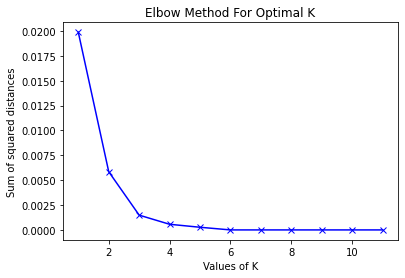

In [32]:
# for determining best clustering number for k-means algorithms, we use elbow method.
from matplotlib import pyplot as plt
Sum_of_squared_distances = []
K = range(1,12)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(berlin_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K")
plt.show()

In [58]:
#Now it is time to divide Berlin in clusters.It is diveded as 3 clusters.
kclusters = 3

berlin_clustering = berlin_rest.drop(["Boroughs"], 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12).fit(berlin_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 2])

In [59]:
merged = berlin_rest.copy()

# add clustering labels
merged["Category"] = kmeans.labels_
merged.rename(columns={"Boroughs": "Borough"}, inplace=True)
merged.head()

,Borough,Italian Restaurant,Category
0,Charlottenburg-Wilmersdorf,0.06,1
1,Friedrichshain-Kreuzberg,0.00,0
2,Lichtenberg,0.08,1
3,Marzahn-Hellersdorf,0.00,0
4,Mitte,0.02,0


In [60]:
dfmerged = merged.merge(berlin_boroughs)
dfmerged.head()

#Sort
dfmerged.sort_values(["Italian Restaurant"], inplace=True, ascending=True)
dfmerged

,Borough,Italian Restaurant,Category,Population,Latitude,Longitude
1,Friedrichshain-Kreuzberg,0.00,0,"281,323",52.500610,13.418630
3,Marzahn-Hellersdorf,0.00,0,"262,015",52.516670,13.583330
7,Reinickendorf,0.00,0,"261,919",52.575450,13.349700
11,Treptow-Köpenick,0.00,0,"259,524",52.433330,13.600000
4,Mitte,0.02,0,"371,407",52.521190,13.424140
5,Neukölln,0.02,0,"327,522",52.480770,13.435410
10,Tempelhof-Schöneberg,0.02,0,"346,108",52.476853,13.361028
6,Pankow,0.04,1,"397,406",52.569250,13.402480
0,Charlottenburg-Wilmersdorf,0.06,1,"336,249",52.499620,13.323160
8,Spandau,0.06,1,"239,942",52.534870,13.202160


In [61]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfmerged['Latitude'], dfmerged['Longitude'], dfmerged['Borough'], dfmerged['Category']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [62]:
merged.loc[merged['Category'] == 0]

,Borough,Italian Restaurant,Category
1,Friedrichshain-Kreuzberg,0.00,0
3,Marzahn-Hellersdorf,0.00,0
4,Mitte,0.02,0
5,Neukölln,0.02,0
7,Reinickendorf,0.00,0
10,Tempelhof-Schöneberg,0.02,0
11,Treptow-Köpenick,0.00,0


In [63]:
merged.loc[merged['Category'] == 1]

,Borough,Italian Restaurant,Category
0,Charlottenburg-Wilmersdorf,0.06,1
2,Lichtenberg,0.08,1
6,Pankow,0.04,1
8,Spandau,0.06,1


In [64]:
merged.loc[merged['Category'] == 2]

,Borough,Italian Restaurant,Category
9,Steglitz-Zehlendorf,0.14,2


### According to our Italian Restaurant number in the clusters ,the best number for clustering is 3. That is why we divided Berlin in 3 parts and figured out number of Italian Restaurant in those parts.In that point,  I  want to link up  a second paremeter, beside Italian Restaurant numbers, that includes which boroughs have more Italian immigrants. 

In [87]:
import csv

website_url = requests.get('https://en.wikipedia.org/wiki/Demographics_of_Berlin').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
#print(soup.prettify())

headers = [header.text for header in table.find_all('th')]

table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
    td = row.find_all('td')
    row = [row.text for row in td]
    rows.append(row)


with open('wiki.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(row for row in rows if row)
    
berlin_italian=pd.read_csv('wiki.csv',encoding= 'unicode_escape')
berlin_italian


,Borough,Population 2010,Area in km2,Largest Non-German ethnic groups\r\n
0,Mitte,"332,100",39.47,"Turks, Arabs, Kurds, Asians, Western Europeans..."
1,Friedrichshain-Kreuzberg,"268,831",20.16,"Turks, Arabs, Africans, Kurds, Chinese\r\n"
2,Pankow,"368,956",103.01,"Poles, Italians, French, Americans, Vietnamese..."
3,Charlottenburg-Wilmersdorf,"320,014",64.72,"Turks, Africans, Russians, Arabs\r\n"
4,Spandau,"225,420",91.91,"Turks, Africans, Russians, Arabs\r\n"
5,Steglitz-Zehlendorf,"293,989",102.50,"Poles, Turks, Croats, Serbs, Koreans\r\n"
6,Tempelhof-Schöneberg,"335,060",53.09,"Turks, Croats, Serbs, Koreans, Africans\r\n"
7,Neukölln,"310,283",44.93,"Arabs, Turks, Kurds, Russians, Africans, Poles..."
8,Treptow-Köpenick,"241,335",168.42,"Russians, Poles, Ukrainians, Vietnamese\r\n"
9,Marzahn-Hellersdorf,"248,264",61.74,"Russians, Vietnamese, Eastern Europeans\r\n"


In [88]:
berlin_italian.drop(['Population 2010', 'Area in km2'],axis=1, inplace=True)

In [93]:
berlin_italian

,Borough,Largest Non-German Ethnic Groups
0,Mitte,"Turks, Arabs, Kurds, Asians, Western Europeans"
1,Friedrichshain-Kreuzberg,"Turks, Arabs, Africans, Kurds, Chinese"
2,Pankow,"Poles, Italians, French, Americans, Vietnamese..."
3,Charlottenburg-Wilmersdorf,"Turks, Africans, Russians, Arabs"
4,Spandau,"Turks, Africans, Russians, Arabs"
5,Steglitz-Zehlendorf,"Poles, Turks, Croats, Serbs, Koreans"
6,Tempelhof-Schöneberg,"Turks, Croats, Serbs, Koreans, Africans"
7,Neukölln,"Arabs, Turks, Kurds, Russians, Africans, Poles"
8,Treptow-Köpenick,"Russians, Poles, Ukrainians, Vietnamese"
9,Marzahn-Hellersdorf,"Russians, Vietnamese, Eastern Europeans"


In [92]:
berlin_italian.rename(columns = {'Largest Non-German ethnic groups\r\n': 'Largest Non-German Ethnic Groups'}, inplace = True)
berlin_italian=berlin_italian.replace( "\r\n", ' ', regex = True)
berlin_italian
dfmerged = dfmerged.merge(berlin_italian)
dfmerged

,Borough,Italian Restaurant,Category,Population,Latitude,Longitude,Largest Non-German Ethnic Groups
0,Reinickendorf,0.00,0,"261,919",52.57545,13.34970,"Turks, Poles, Serbs, Croats, Arabs, Italians"
1,Pankow,0.04,1,"397,406",52.56925,13.40248,"Poles, Italians, French, Americans, Vietnamese..."


In [66]:
berlin_italian = berlin_italian[berlin_italian['Largest Non-German ethnic groups\r\n'].str.contains('Italian',regex=False)]
berlin_italian

C:\Users\OBO\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Borough,Largest Non-German ethnic groups\r\n
2,Pankow,"Poles, Italians, French, Americans, Vietnamese..."
11,Reinickendorf,"Turks, Poles, Serbs, Croats, Arabs, Italians\r\n"


It can be seen, of course according to Wikipedia, 2 Boroughs have Italian living groups.

### I merged the tables, one of them shows Italian immigrants boroughs and the second one shows Italian restuarants number

In [67]:
dfmerged = dfmerged.merge(berlin_italian)
dfmerged

,Borough,Italian Restaurant,Category,Population,Latitude,Longitude,Largest Non-German ethnic groups\r\n
0,Reinickendorf,0.00,0,"261,919",52.57545,13.34970,"Turks, Poles, Serbs, Croats, Arabs, Italians\r\n"
1,Pankow,0.04,1,"397,406",52.56925,13.40248,"Poles, Italians, French, Americans, Vietnamese..."


#### After merging the table includes Italian restuarant numbers and  the table includes more  Italian immigrants living boroughs, the results say us there are 2 options.I am going to pick Pankow up for a new Italin Restaurant.